In [1]:
import pandas as pd
import numpy as np

In [2]:
from statsmodels.tsa.api import adfuller, kpss, SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (17, 10)

In [4]:
df = pd.read_csv('./Aquifer_Petrignano.csv')

In [5]:
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [6]:
df.set_index('Date', inplace=True)

NaN заполняем с помощью интерполяции (i.e. регрессия)

In [7]:
data = df['Depth_to_Groundwater_P24'].interpolate()
data.head()

Date
14/03/2006   -22.48
15/03/2006   -22.38
16/03/2006   -22.25
17/03/2006   -22.38
18/03/2006   -22.60
Name: Depth_to_Groundwater_P24, dtype: float64

In [8]:
data.describe()

count    5223.000000
mean      -26.279945
std         3.314307
min       -34.470000
25%       -28.265000
50%       -26.020000
75%       -23.840000
max       -19.660000
Name: Depth_to_Groundwater_P24, dtype: float64

Вроде без выбросов - норм

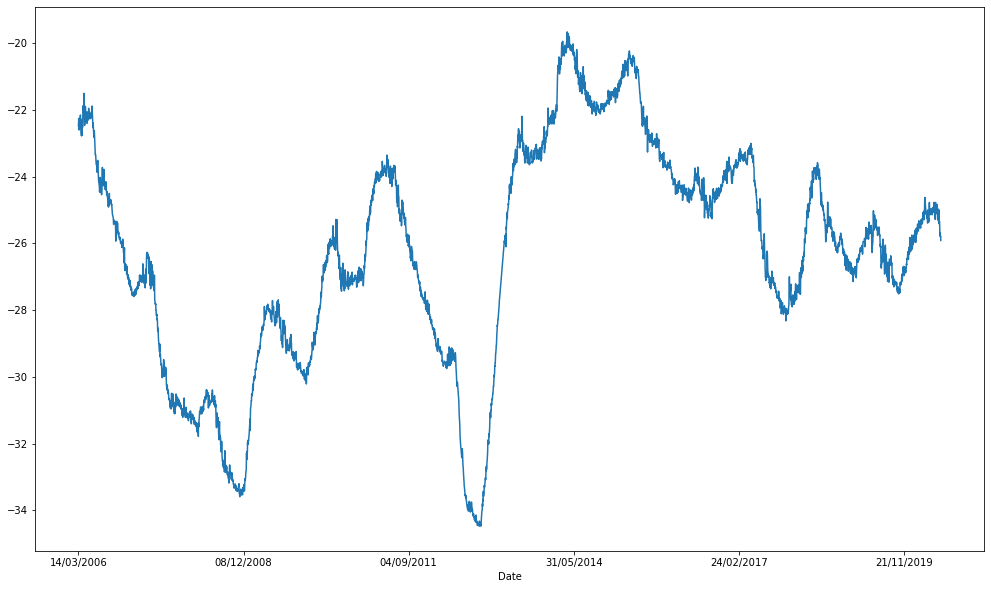

In [9]:
data.plot()

In [10]:
train_part = 0.8
train_size = int(train_part * len(data))
train, test = data[:train_size], data[train_size:]

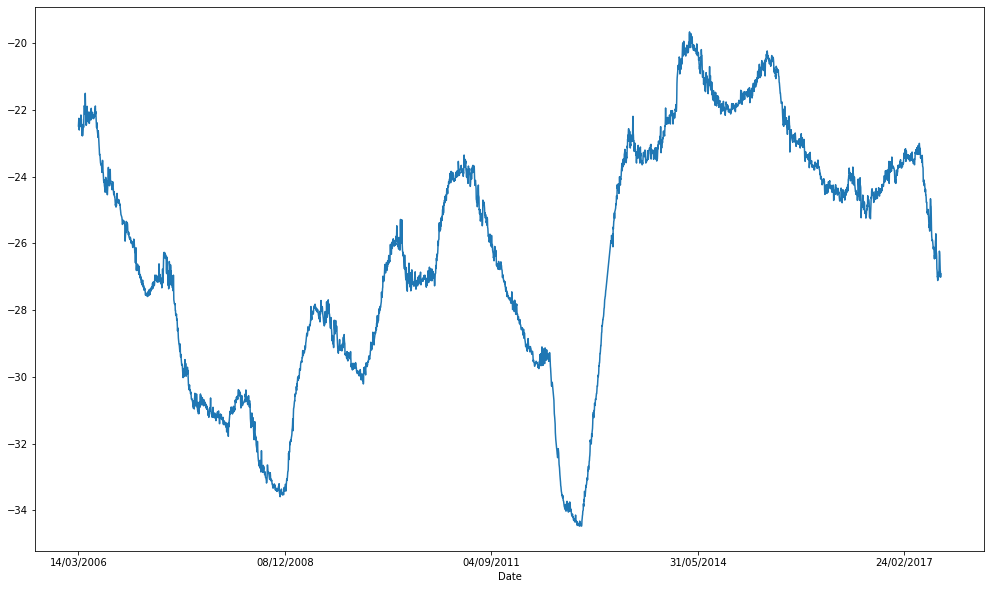

In [11]:
train.plot()

Убираю годичную сезонность

In [12]:
decomposition = seasonal_decompose(train, period=365)

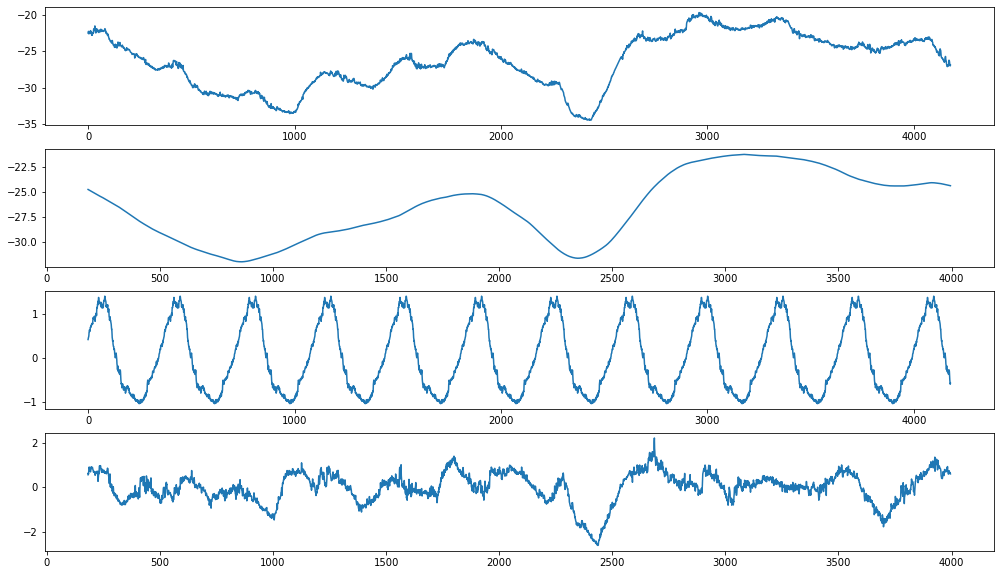

In [13]:
_, ax = plt.subplots(4, 1)
ax[0].plot(decomposition.observed.values)
ax[1].plot(decomposition.trend.values)
ax[2].plot(decomposition.seasonal.values)
ax[3].plot(decomposition.resid.values)

In [14]:
obs, trend, seasonal, resid = decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid
train_without_seasonal = obs - seasonal

In [15]:
y_seasonal = seasonal.copy()

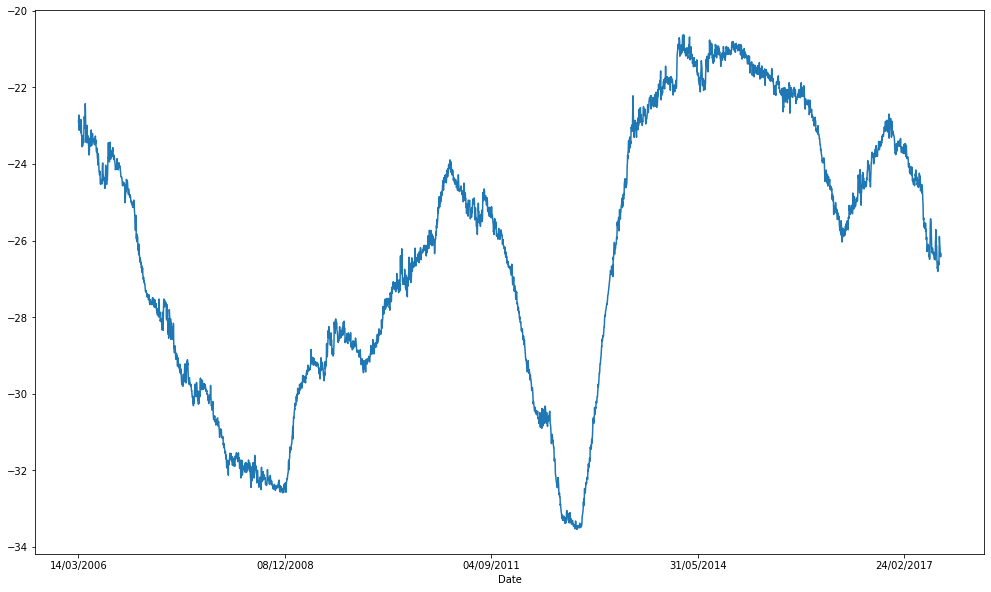

In [16]:
train_without_seasonal.plot()

Убираю недельную сезонность

In [17]:
decomposition = seasonal_decompose(train_without_seasonal, period=7)

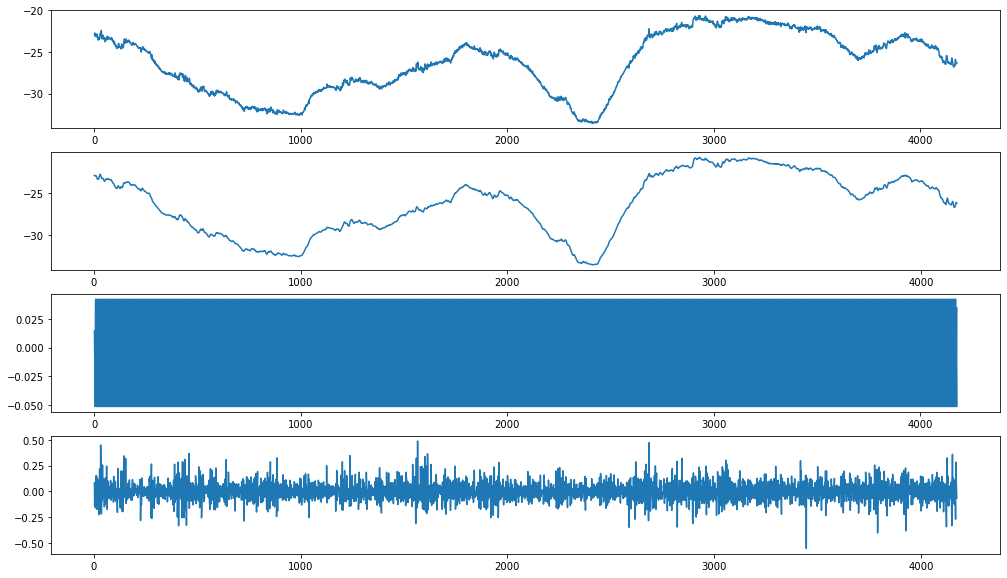

In [18]:
_, ax = plt.subplots(4, 1)
ax[0].plot(decomposition.observed.values)
ax[1].plot(decomposition.trend.values)
ax[2].plot(decomposition.seasonal.values)
ax[3].plot(decomposition.resid.values)

In [19]:
obs, trend, seasonal, resid = decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid
train_without_seasonal = obs - seasonal

In [20]:
w_seasonal = seasonal.copy()

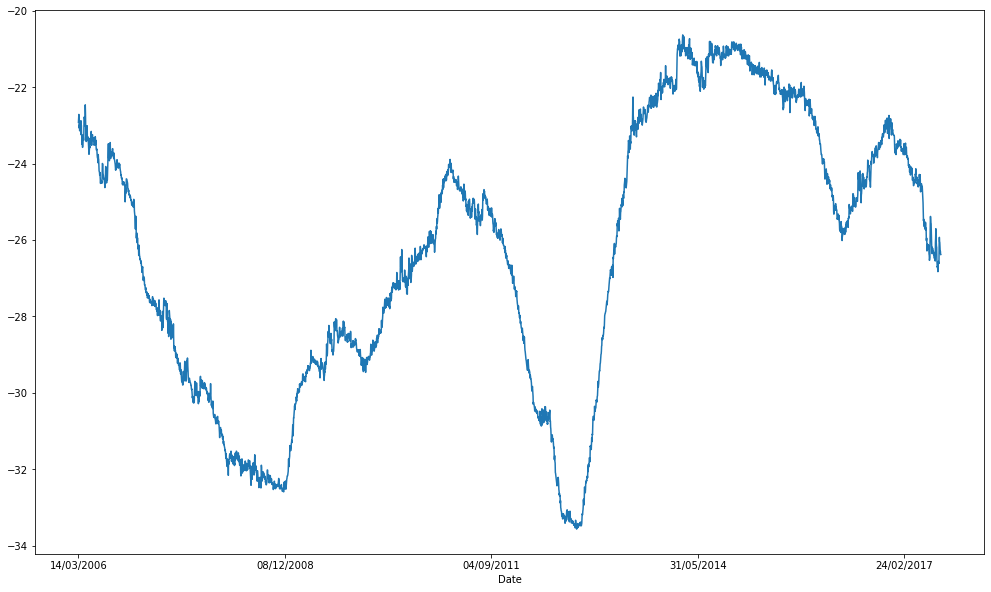

In [21]:
train_without_seasonal.plot()

In [22]:
adfuller(train_without_seasonal)

(-1.7530523252277792,
 0.4040061812438117,
 30,
 4147,
 {'1%': -3.431927852028984,
  '5%': -2.862237208417471,
  '10%': -2.5671411303007297},
 -6466.6340148344425)

In [23]:
kpss(train_without_seasonal)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(4.849842300540199,
 0.01,
 31,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [24]:
train_diff = train_without_seasonal.diff().dropna()

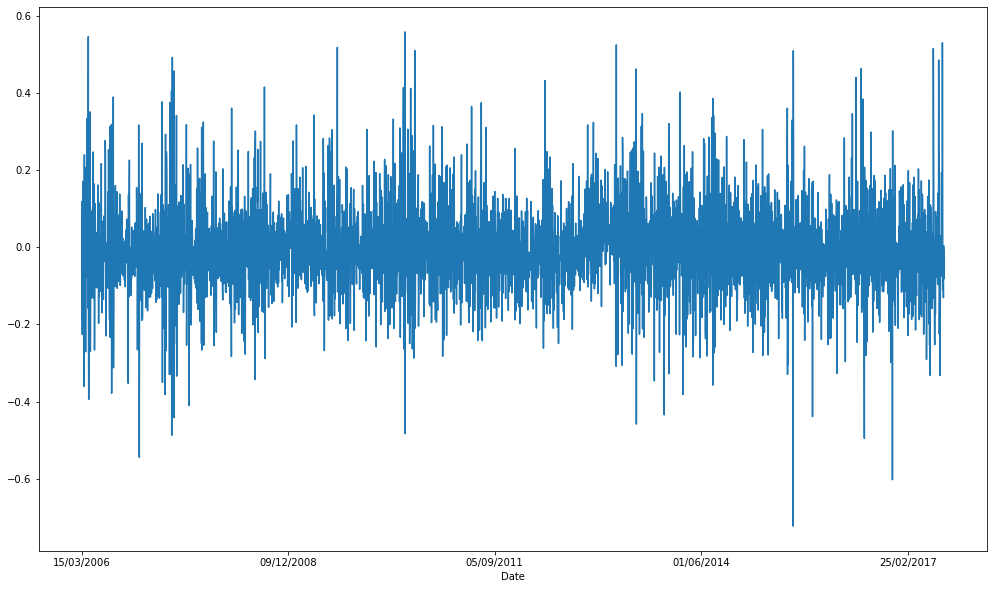

In [25]:
train_diff.plot()

In [26]:
adfuller(train_diff)

(-7.049388885102844,
 5.577384465693519e-10,
 29,
 4147,
 {'1%': -3.431927852028984,
  '5%': -2.862237208417471,
  '10%': -2.5671411303007297},
 -6463.0131426843)

In [27]:
kpss(train_diff)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


(0.41039939618941795,
 0.07267267405628537,
 31,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

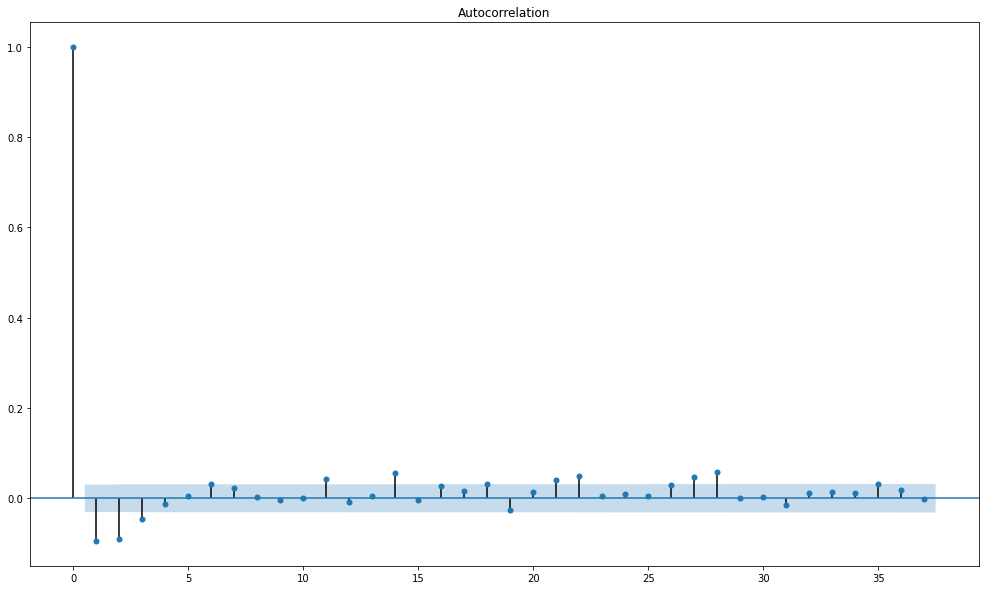

In [28]:
plot_acf(train_diff)
plt.show()

Эть, неплохо:
q = 3

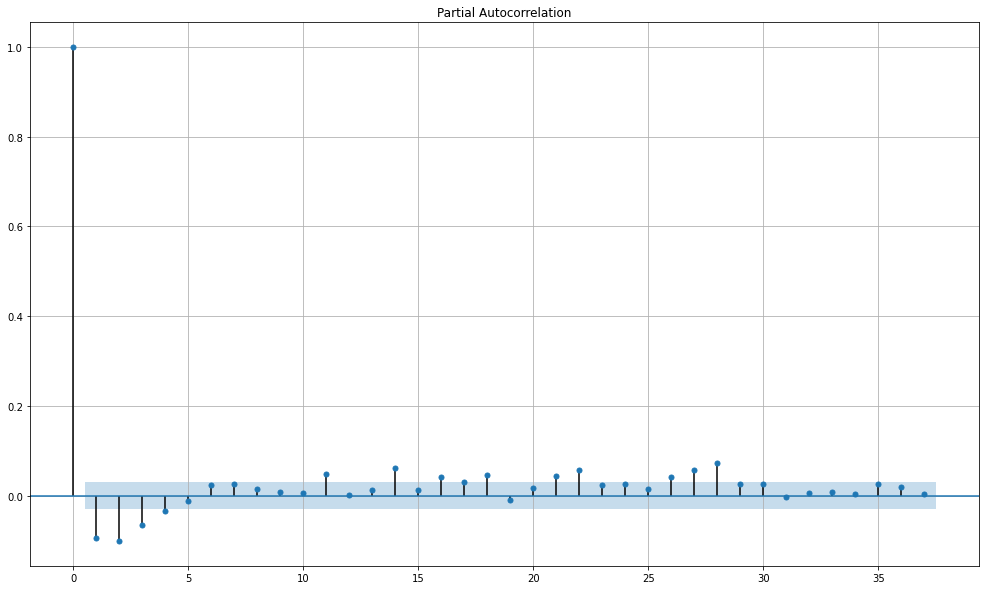

In [29]:
plot_pacf(train_diff)
plt.grid()

p = 4

Перед обучением еще вычтем уровень - среднее значение

In [30]:
mean = np.mean(train_without_seasonal)
mean

-26.337607478925925

In [31]:
train_data = train_without_seasonal.apply(lambda x: x - mean)

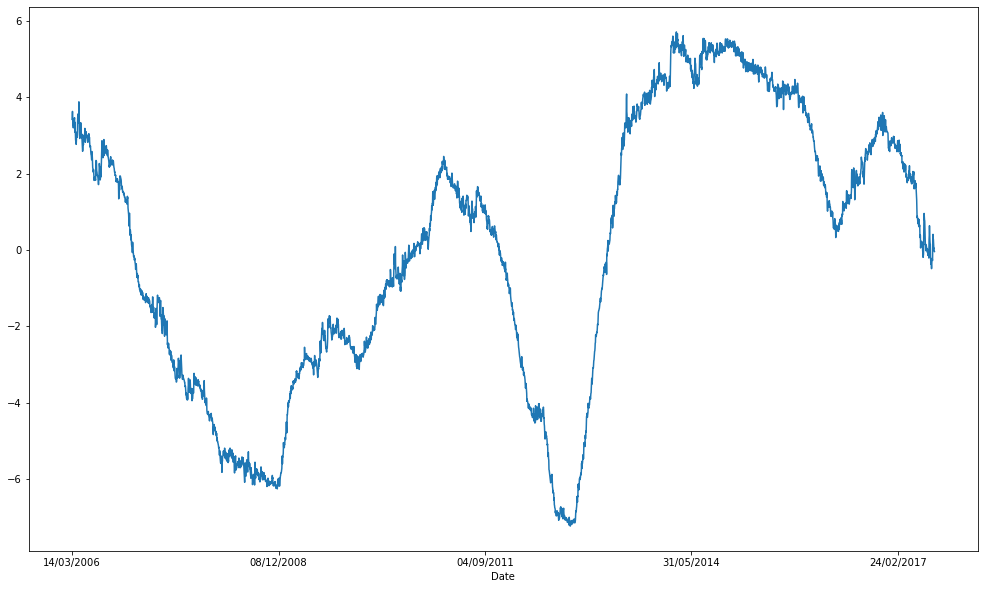

In [32]:
train_data.plot()

In [33]:
p, d, q = 4, 1, 3

In [34]:
model = None
best_aic = 1000000000000000000000000

In [35]:
from warnings import filterwarnings
filterwarnings('ignore')
for p_ in range(p, -1, -1):
    for q_ in range(q, -1, -1):
        try:
            print(f'(p, d, q) = ({p_}, {d}, {q_})')
            m = SARIMAX(train_data, order=(p_, d, q_)).fit()
            if (m.aic <= best_aic):
                print(f'Now best is ({p_}, {d}, {q_})')
                best_aic, model = m.aic, m
        except Exception as e:
            pass

(p, d, q) = (4, 1, 3)
Now best is (4, 1, 3)
(p, d, q) = (4, 1, 2)
Now best is (4, 1, 2)
(p, d, q) = (4, 1, 1)
(p, d, q) = (4, 1, 0)
(p, d, q) = (3, 1, 3)
(p, d, q) = (3, 1, 2)
Now best is (3, 1, 2)
(p, d, q) = (3, 1, 1)
(p, d, q) = (3, 1, 0)
(p, d, q) = (2, 1, 3)
(p, d, q) = (2, 1, 2)
(p, d, q) = (2, 1, 1)
(p, d, q) = (2, 1, 0)
(p, d, q) = (1, 1, 3)
(p, d, q) = (1, 1, 2)
(p, d, q) = (1, 1, 1)
(p, d, q) = (1, 1, 0)
(p, d, q) = (0, 1, 3)
(p, d, q) = (0, 1, 2)
(p, d, q) = (0, 1, 1)
(p, d, q) = (0, 1, 0)


In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4178
Model:               SARIMAX(3, 1, 2)   Log Likelihood                3250.577
Date:                Tue, 12 Jan 2021   AIC                          -6489.153
Time:                        01:44:57   BIC                          -6451.129
Sample:                             0   HQIC                         -6475.704
                               - 4178                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6207      0.035     46.227      0.000       1.552       1.689
ar.L2         -0.6578      0.032    -20.532      0.000      -0.721      -0.595
ar.L3          0.0339      0.016      2.111      0.035       0.002       0.065
ma.L1         -1.7568      0.034    -52.319      0.000      -1.823      -1.691
ma.L2          0.7644      0.033     22.964      0.000       0.699       0.830
sigma2         0.0123      0.000     71.576      0.000       0.012       0.013
===================================================================================
Ljung-Box (Q):                       57.59   Jarque-Bera (JB):              1628.34
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.31
Prob(H) (two-sided):                  0.12   Kurtosis:                         6.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

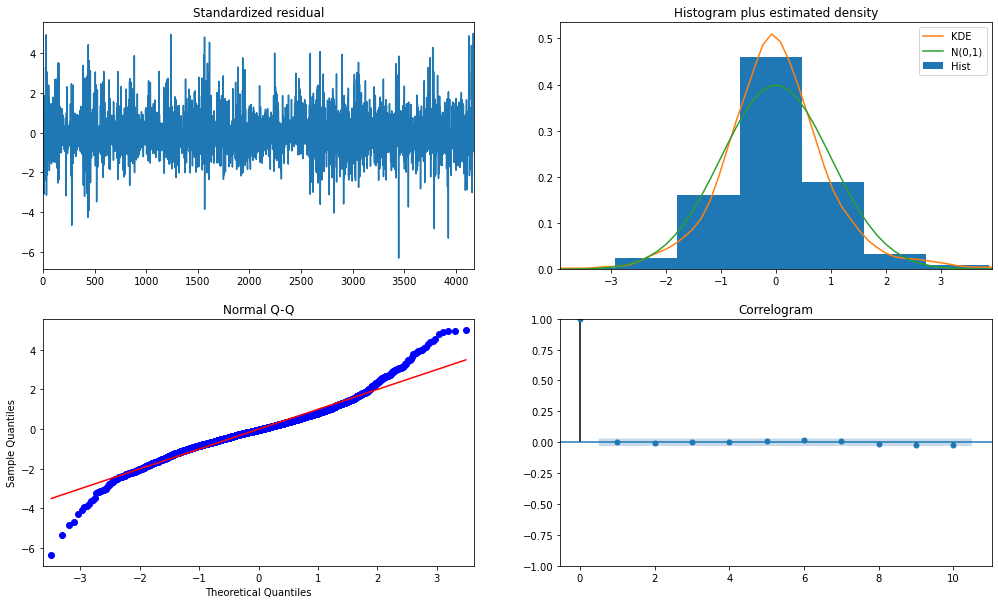

In [37]:
model.plot_diagnostics()
plt.show()

Тут надо впомнить, что модель построена для ряда, из которого вычли уровень, и две сезонности.
Значит делаем все в обратном порядке для прогноза:
- прибавляем уровень
- прогнозируем недельную сезонность
- прогнозируем годовую сезонность

In [38]:
to_forecast = len(test)
to_forecast

1045

In [39]:
forecast = model.forecast(steps=to_forecast)

Добавляем уровень

In [40]:
forecast = forecast.apply(lambda x: x + mean)

Добавляем недельную сезонность обратно

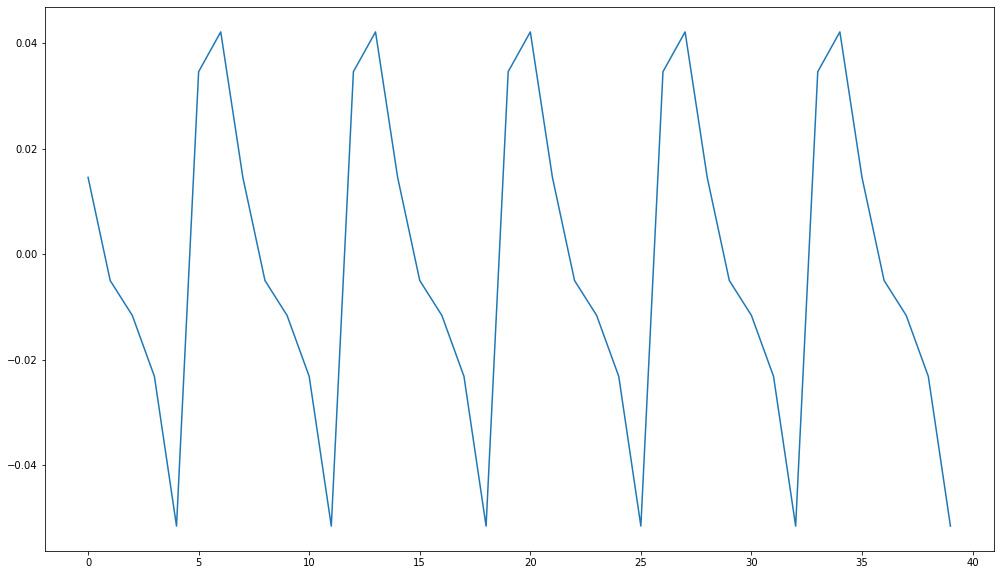

In [41]:
plt.plot(w_seasonal.values[:40])

In [42]:
for i in range(7):
    if w_seasonal[i] == w_seasonal[-1]:
        print(i)

5


In [43]:
w_seasonal_range = w_seasonal.values[6:6+7]

In [44]:
w_seasonal_forecast = np.array([
    w_seasonal_range[i % 7] for i in range(to_forecast)
])
w_seasonal_forecast

array([ 0.04210717,  0.0145585 , -0.00498411, ...,  0.0345693 ,
        0.04210717,  0.0145585 ])

In [45]:
forecast += w_seasonal_forecast

Добавляем годовую сезонность обратно

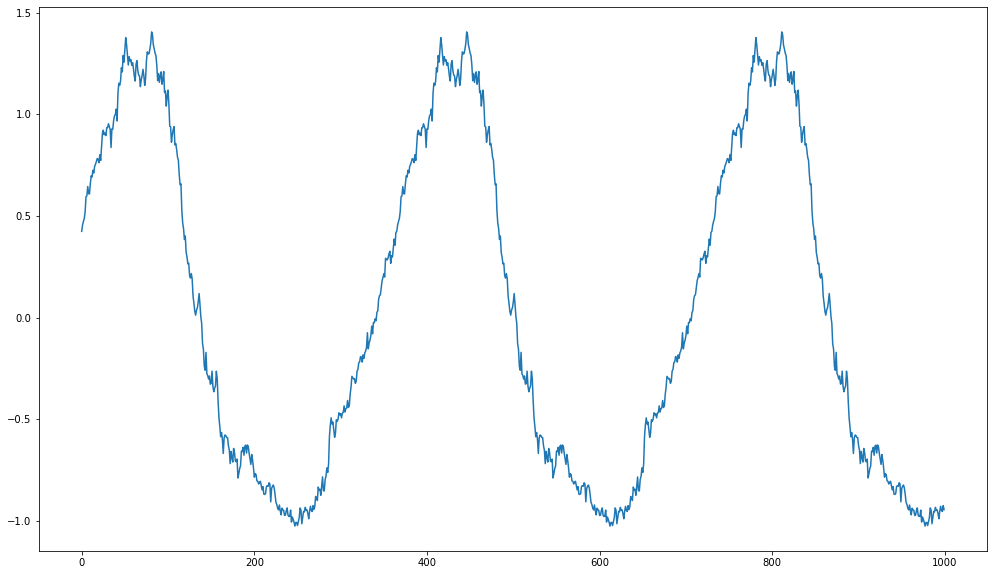

In [46]:
plt.plot(y_seasonal.values[:1000])

In [47]:
for i in range(365):
    if y_seasonal[i] == y_seasonal[-1]:
        print(i)

162


In [48]:
y_seasonal_range = y_seasonal.values[162:162+365]

In [49]:
y_seasonal_forecast = np.array([
    y_seasonal_range[i % 365] for i in range(to_forecast)
])
y_seasonal_forecast

array([-0.56518384, -0.59925782, -0.66831535, ...,  0.85577232,
        0.82613739,  0.78857643])

In [50]:
forecast += y_seasonal_forecast

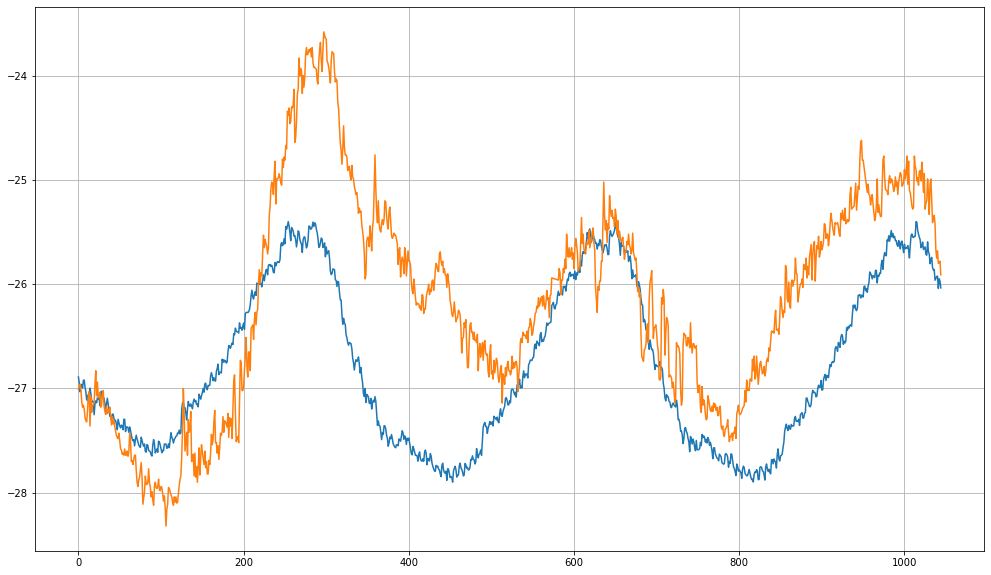

In [51]:
plt.plot(forecast.values)
plt.plot(test.values)
plt.grid()

Ну вообще это хреново))))
Если взглянуть на остатки, там будет лютая боль, но это из-за того, что тренд у нас никак аналитически не приближается, и избавлялись от него мы с помощью дифференцирования

In [60]:
train

Date
14/03/2006   -22.48
15/03/2006   -22.38
16/03/2006   -22.25
17/03/2006   -22.38
18/03/2006   -22.60
              ...  
16/08/2017   -26.58
17/08/2017   -26.80
18/08/2017   -26.85
19/08/2017   -27.01
20/08/2017   -26.91
Name: Depth_to_Groundwater_P24, Length: 4178, dtype: float64

In [61]:
test

Date
21/08/2017   -27.01
22/08/2017   -26.97
23/08/2017   -26.96
24/08/2017   -27.01
25/08/2017   -27.13
              ...  
26/06/2020   -25.68
27/06/2020   -25.80
28/06/2020   -25.80
29/06/2020   -25.78
30/06/2020   -25.91
Name: Depth_to_Groundwater_P24, Length: 1045, dtype: float64

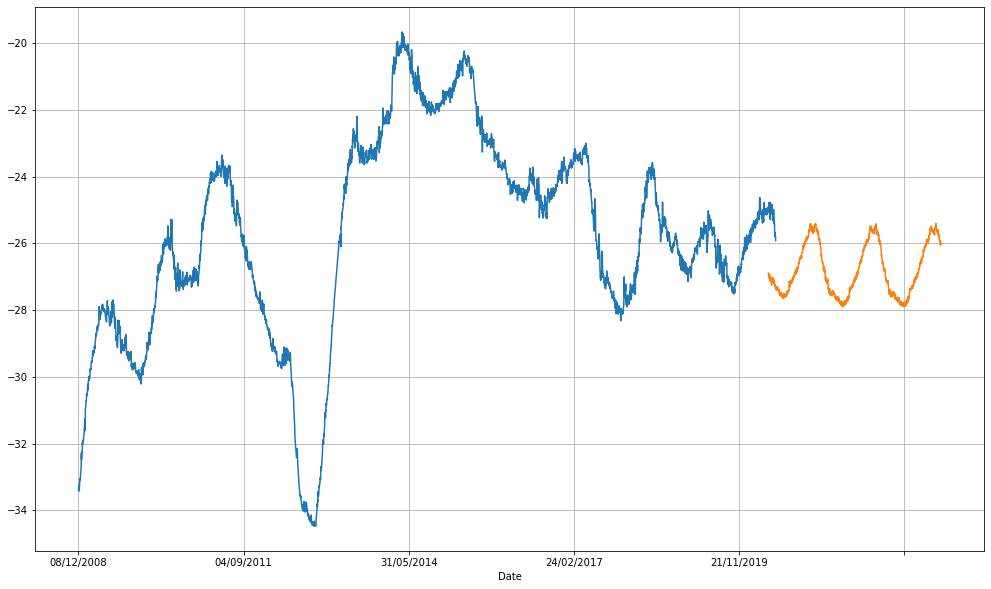

In [64]:
data[1000:].plot()
forecast.plot()
plt.grid()

Но если в принципе смотреть на вещи реально, то результат вполне неплох)